In [79]:
import torch
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt

In [80]:
# Choose GPU if available, otherwise fallback to CPU
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")
print(DEVICE)

cpu


In [81]:
# Set variances for initial states
# variance2 = 10
# variance1 = 1 / variance2 # Inverse variance
variance2 = 10 ** 0.8
variance1 = 10 ** -0.5 # Inverse variance

N = 500  # Number of modes

In [82]:
# Helper function to draw 2D scatter plots of sampled Gaussian distributions
def draw_scatter(samples1, samples2, label1, label2):
    plt.figure(figsize=(6, 6))
    plt.scatter(samples1, samples2, s=10, alpha=0.6, edgecolors='k', linewidths=0.3)
    plt.xlim(-10, 10)
    plt.ylim(-10, 10)
    plt.xlabel(label1)
    plt.ylabel(label2)
    plt.title('Samples from Gaussian State')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.gca().set_aspect('equal')  # Make x and y axis scales equal
    plt.show()

# Function to check if a matrix is positive semidefinite
def check_psd(matrix, tol=1e-8):
    if not np.allclose(matrix, matrix.T, atol=tol):
        raise ValueError("Matrix is not symmetric.")  # PSD requires symmetry
    eigenvalues = np.linalg.eigvalsh(matrix)  # Eigenvalues for symmetric matrix
    min_eig = np.min(eigenvalues)
    is_psd = min_eig >= -tol  # Allow small numerical errors
    violation = 0 if is_psd else abs(min_eig)
    return is_psd, violation

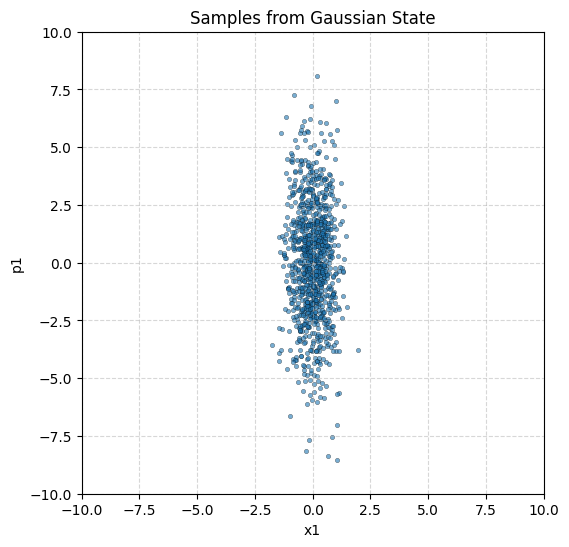

In [83]:
# Initialize diagonal covariance matrix with alternating variances
initial_covariance = torch.zeros((2*N,2*N)).to(DEVICE)
for i in range(0,2*N,4): 
    initial_covariance[i][i] = variance1
    initial_covariance[i+1][i+1] = variance2
    initial_covariance[i+2][i+2] = variance2
    initial_covariance[i+3][i+3] = variance1

# Extract 2x2 submatrix for x1, p1
x_indices = [0, 1]
sigma_out = initial_covariance[np.ix_(x_indices, x_indices)].cpu()
mean_x = np.zeros(2)  # Zero mean
samples = np.random.multivariate_normal(mean_x, sigma_out, size=1000)  # Sample points
draw_scatter(samples.T[0], samples.T[1], 'x1', 'p1')  # Visualize

In [84]:
# Define phase shift transformation matrix for a specific mode
def phase_shift90(mode, phi=np.pi/2):
    S = torch.eye(2*N, device=DEVICE)
    cos_phi = np.cos(phi)
    sin_phi = np.sin(phi)
    idx = 2 * mode
    S[idx, idx] = cos_phi
    S[idx, idx+1] = sin_phi
    S[idx+1, idx] = -sin_phi
    S[idx+1, idx+1] = cos_phi
    return S

# Define beamsplitter transformation between two modes
def beam_splitter(mode1, mode2, theta=np.pi/4):
    S = torch.eye(2 * N, device=DEVICE)
    c = np.cos(theta)
    s = np.sin(theta)
    i = 2 * mode1
    j = 2 * mode2
    indices = [i, i+1, j, j+1]
    # BS_block = torch.tensor([
    #     [c, 0,  s, 0],
    #     [0, c,  0, s],
    #     [-s, 0, c, 0],
    #     [0, -s, 0, c]
    # ], dtype=S.dtype, device=DEVICE)
    BS_block = torch.tensor([
        [c, 0, -s, 0],
        [0, c,  0,-s],
        [s, 0,  c, 0],
        [0, s,  0, c]
    ], dtype=S.dtype, device=DEVICE)
    S[np.ix_(indices, indices)] = BS_block
    return S

In [85]:
# Build full transformation matrix S by chaining phase shifts and beamsplitters

# FIRST beam-splitter
S = beam_splitter(0,1)
for i in tqdm(range(2,N-1,2)):
    S = beam_splitter(i, i+1) @ S

# Second beam-splitter
for i in tqdm(range(1,N-1,2)):
    S = beam_splitter(i+1, i) @ S

# for i in tqdm(range(2, N-1,2)):  # Iterate over all remaining modes
#     S = beam_splitter(i, i-1,theta=np.pi/4) @ S

100%|██████████| 249/249 [00:02<00:00, 122.25it/s]


In [86]:
# Apply transformation to the initial covariance matrix
final_covariance = (S @ initial_covariance @ (S.T)).cpu()

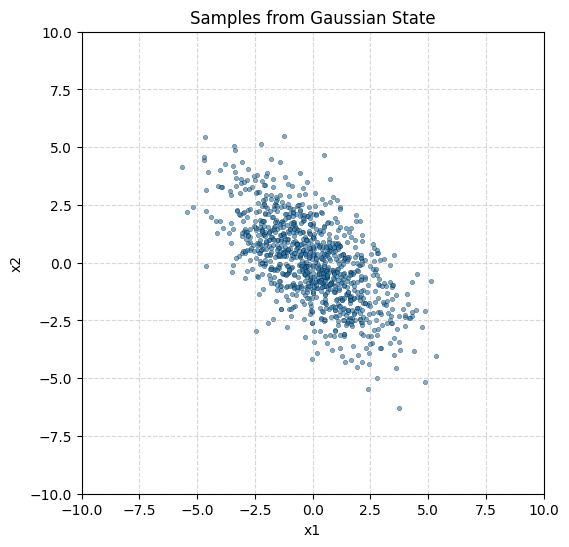

In [87]:
# Extract 2x2 submatrix for x1, p1
x_indices = [0, 2]
sigma_out = final_covariance[np.ix_(x_indices, x_indices)].cpu()
mean_x = np.zeros(2)  # Zero mean
samples = np.random.multivariate_normal(mean_x, sigma_out, size=1000)  # Sample points
draw_scatter(samples.T[0], samples.T[1], 'x1', 'x2')  # Visualize

In [88]:
# Compute nullifiers across the chain
def find_nullifiersX(covariance, a):
    nullifiers = []
    
    # a = [1, 1, 1, -1]
    
    # First special nullifier: δ = xA1+xB1+xA2-xB2
    indices = [2,4,6,8]
    sigma_out = final_covariance[np.ix_(indices, indices)].cpu()
    mean_x = np.zeros(len(indices))
    condition, _ = check_psd(sigma_out)
    if not condition:
        raise "not positive semidefinite 0"
    samples = np.random.multivariate_normal(mean_x, sigma_out, size=100000)
    # nullifiers += [(samples[:,0] + samples[:,1]-samples[:,2]+samples[:,3]).var()]
    # nullifiers += [(samples[:,0] + samples[:,1] + samples[:,2] - samples[:,3]).var()]
    nullifiers += [(a[0] * samples[:,0] + a[1] * samples[:,1] + a[2] * samples[:,2] + a[3] * samples[:,3]).var()]

    # Remaining nullifiers δ = xAk+xBk+xAk+1-xBk+1
    for i in tqdm(range(3, N-3,2)):
        indices = [i*2, i*2+2, i*2+4, i*2+6]
        sigma_out = final_covariance[np.ix_(indices, indices)].cpu()
        mean_x = np.zeros(len(indices))
        condition, _ = check_psd(sigma_out)
        if not condition:
            raise "not positive semidefinite " + str(i)
        samples = np.random.multivariate_normal(mean_x, sigma_out, size=100000)
        # nullifiers += [(samples[:,0] + samples[:,1]-samples[:,2]+samples[:,3]).var()]
        # nullifiers += [(samples[:,0] + samples[:,1] + samples[:,2] - samples[:,3]).var()]
        nullifiers += [(a[0] * samples[:,0] + a[1] * samples[:,1] + a[2] * samples[:,2] + a[3] * samples[:,3]).var()]
    
    return nullifiers

def find_nullifiersP(covariance):
    nullifiers = []
    
    # First special nullifier: δ = pA1+pB1-pA2+pB2
    indices = [3,5,7,9]
    sigma_out = final_covariance[np.ix_(indices, indices)].cpu()
    mean_x = np.zeros(len(indices))
    condition, _ = check_psd(sigma_out)
    if not condition:
        raise "not positive semidefinite 0"
    samples = np.random.multivariate_normal(mean_x, sigma_out, size=100000)
    # nullifiers += [(samples[:,0] + samples[:,1] + samples[:,2] - samples[:,3]).var()]
    nullifiers += [(samples[:,0] + samples[:,1] - samples[:,2] + samples[:,3]).var()]
    

    # Remaining nullifiers δ = pAk+pBk-pAk+1+pBk+1
    for i in tqdm(range(3, N-3,2)):
        indices = [i*2+1, i*2+3, i*2+5, i*2+7]
        sigma_out = final_covariance[np.ix_(indices, indices)].cpu()
        mean_x = np.zeros(len(indices))
        condition, _ = check_psd(sigma_out)
        if not condition:
            raise "not positive semidefinite " + str(i)
        samples = np.random.multivariate_normal(mean_x, sigma_out, size=100000)
        # nullifiers += [(samples[:,0] + samples[:,1] + samples[:,2] - samples[:,3]).var()]
        nullifiers += [(samples[:,0] + samples[:,1] - samples[:,2] + samples[:,3]).var()]
    
    return nullifiers

In [89]:
a = [1, 1, 1, -1]

  2%|▏         | 6/247 [00:00<00:04, 53.15it/s]

100%|██████████| 247/247 [00:03<00:00, 62.13it/s]


1.264945242472253


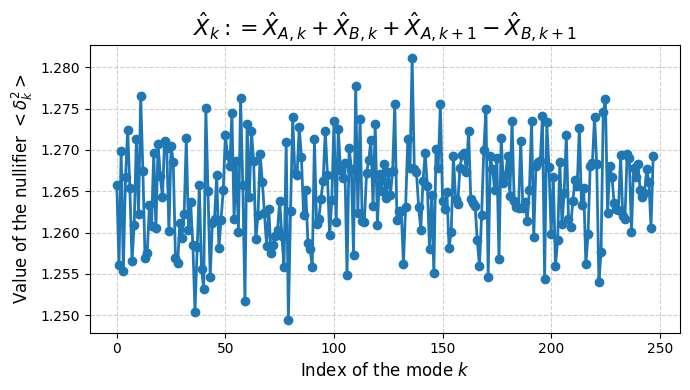

In [90]:
# Calculate all nullifier variances
result = find_nullifiersX(final_covariance,a)

# (Optional) print average value
print(np.array(result).mean())

# Plot result with polished aesthetics
plt.figure(figsize=(7, 4))
plt.plot(result, linewidth=2, marker='o')
plt.title('$\hat{X}_k := \hat{X}_{A,k} + \hat{X}_{B,k} + \hat{X}_{A,k+1} - \hat{X}_{B,k+1}$', fontsize=16)
plt.xlabel(f"Index of the mode $k$", fontsize=12)
plt.ylabel(f"Value of the nullifier $<\\delta^2_k>$", fontsize=12)
# plt.ylim(0, 2)  # Set y-axis limits from 0 to 2
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

  0%|          | 0/247 [00:00<?, ?it/s]

100%|██████████| 247/247 [00:03<00:00, 68.94it/s]


1.2644381754941296


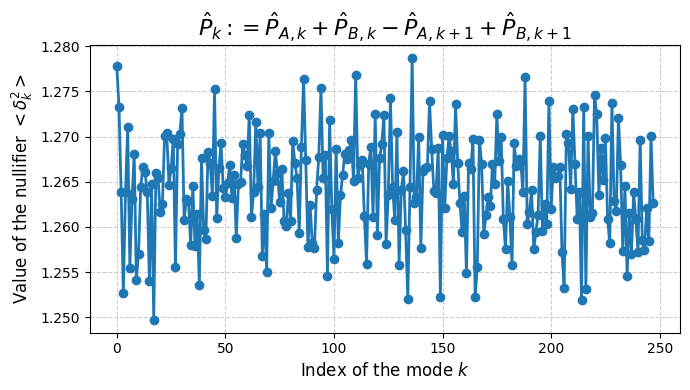

In [91]:
# Calculate all nullifier variances
result = find_nullifiersP(final_covariance)

# (Optional) print average value
print(np.array(result).mean())

# Plot result with polished aesthetics
plt.figure(figsize=(7, 4))
plt.plot(result, linewidth=2, marker='o')
plt.title('$\hat{P}_k := \hat{P}_{A,k} + \hat{P}_{B,k} - \hat{P}_{A,k+1} + \hat{P}_{B,k+1}$', fontsize=16)
plt.xlabel(f"Index of the mode $k$", fontsize=12)
plt.ylabel(f"Value of the nullifier $<\\delta^2_k>$", fontsize=12)
# plt.ylim(0, 2)  # Set y-axis limits from 0 to 2
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()